In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import pytorch_lightning as pl
import matplotlib.pylab as plt
from torchinfo import summary
import time

In [2]:
%load_ext tensorboard

In [3]:
class CIFARDataModule(pl.LightningDataModule):
    def __init__(self, classes, transforms=transforms.ToTensor(), data_dir='./', batch_size=64, num_workers=0, pin_memory=True):
        super().__init__()
        self.pin_memory=pin_memory
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transforms = transforms
        self.classes = classes
        self.num_workers = num_workers
    
    def prepare_data(self):
        datasets.CIFAR10(root=self.data_dir, train=True, download=True)
        datasets.CIFAR10(root=self.data_dir, train=False, download=True)

    def setup(self, stage = None):
        if stage in (None, 'fit'):
            self.train_dset = datasets.CIFAR10(root=self.data_dir, train=True, transform=self.transforms)
            self.val_dset = datasets.CIFAR10(root=self.data_dir, train=False, transform=self.transforms)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dset, batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=self.pin_memory)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dset, batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=self.pin_memory)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(torch.utils.data.Subset(self.train_dset, range(100)), batch_size=self.batch_size, num_workers=self.num_workers)

In [4]:
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
cifardm = CIFARDataModule(classes)
cifardm.prepare_data()
cifardm.setup()
test_dset = list(cifardm.test_dataloader())
print(cifardm.classes)

Files already downloaded and verified
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


tensor(1.)
torch.Size([3, 32, 32])
tensor(0.9961)
torch.Size([3, 32, 32])
tensor(1.)
torch.Size([3, 32, 32])
tensor(0.9176)
torch.Size([3, 32, 32])
tensor(0.9961)
torch.Size([3, 32, 32])
tensor(0.9882)
torch.Size([3, 32, 32])
tensor(0.9765)
torch.Size([3, 32, 32])
tensor(0.9725)
torch.Size([3, 32, 32])
tensor(0.9882)
torch.Size([3, 32, 32])


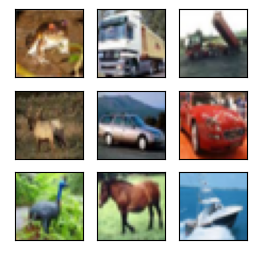

In [5]:
plt.figure(figsize=(3,3))
for ix, photo in enumerate(test_dset[0][0][:9]):
    plt.subplot(3, 3, ix + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    print(photo.max())
    print(photo.shape)
    plt.imshow(photo.permute(1,2,0), cmap=plt.cm.binary)
plt.show()

W PyTorchu CrossEntropyLoss, który działa właśnie jako "categorical crossentropy", wymagany jest numery klasy jako wartość oczekiwana, w związku z czym nie będę robił one hot encoding.  
W pytorchu możnaby to zrobić przy pomocy torch.nn.functional.one_hot()  
Odnośnie zdjęć, widzimy że są bardzo różnorodne, mamy 10 klas, bardzo się różniących (przynajmniej na poziomie abstrakcji).  
Dodatkowo nasz dataloader transformuje zdjęcia tak by były znormalizowane i zawierały się w zakresie [0,1] 

In [6]:
class minCIFAR(pl.LightningModule):
    def __init__(self, lr=0.01, momentum=0.9):
        super(minCIFAR, self).__init__()
        self.lr = lr
        self.momentum = momentum
        self.layer_1 = torch.nn.Sequential(
            torch.nn.Conv2d(3,5,kernel_size=3,padding='same'),
            torch.nn.Sigmoid()
        )
        self.layer_2 = torch.nn.Sequential(
            torch.nn.Conv2d(5,5,kernel_size=3,padding='same'),
            torch.nn.Sigmoid(),
            torch.nn.MaxPool2d(kernel_size=8)
        )
        self.layer_out = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(5*4*4,10),
            torch.nn.Softmax(dim=1)
        )
        self.train_loss = []
        self.train_accuracy = []
        self.val_loss = []
        self.val_accuracy = []
    
    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_out(x)
        return x
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr, momentum=self.momentum)

    def categorical_crossentropy(self, res, exp):
        return F.cross_entropy(res, exp)
    
    def training_step(self, train_batch, batch_idx):
        x,y = train_batch
        results = self.forward(x)
        loss = self.categorical_crossentropy(results, y)
        # self.log('train_los', loss)
        # self.log('train_acc', sum(y==results.argmax(dim=1))/len(y))
        self.train_loss += [loss]
        self.train_accuracy += [sum(y==results.argmax(dim=1))/len(y)]
        return loss

    def validation_step(self, val_batch, batch_idx):
        x,y = val_batch
        results = self.forward(x)
        loss = self.categorical_crossentropy(results, y)
        # self.log('val_loss', loss)
        # self.log('val_acc', sum(y==results.argmax(dim=1))/len(y))
        self.val_loss += [loss]
        self.val_accuracy += [sum(y==results.argmax(dim=1))/len(y)]
        return loss


Zaimplementowałem tę architekturę jako classę pytorch lightning, korzystająć z torch'owych warstw: Sequential, Conv2d, Linear, MaxPool2d, oraz funkcji aktywacji Sigmoid, Softmax.  
Dodatkowo nadpisałem metodę forward, która opisuje jak warstwy powinny się zachować.  
Dodatkowo zaimplementowałem metody configure optimizers żeby wygodnie zdefinicować optymizer, categorical_crossentropy żeby mieć funkcję loss, training_step i val_step, żeby zdefinniować kolejne kroki uczenia i walidacji.   
Na taki model składa się 1180 parametrów, co potwierdza poniższe summary.

In [7]:
m=minCIFAR()
summary(m)

Layer (type:depth-idx)                   Param #
minCIFAR                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       140
│    └─Sigmoid: 2-2                      --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-3                       230
│    └─Sigmoid: 2-4                      --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-3                        --
│    └─Flatten: 2-6                      --
│    └─Linear: 2-7                       810
│    └─Softmax: 2-8                      --
Total params: 1,180
Trainable params: 1,180
Non-trainable params: 0

In [8]:
for photo in test_dset[0][0][:10]:
    print(m(torch.unsqueeze(photo, dim=0)))

tensor([[0.1706, 0.1426, 0.0938, 0.1015, 0.0604, 0.0706, 0.0933, 0.1020, 0.0521,
         0.1132]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1708, 0.1426, 0.0940, 0.1013, 0.0604, 0.0702, 0.0931, 0.1020, 0.0521,
         0.1136]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1706, 0.1428, 0.0938, 0.1012, 0.0602, 0.0702, 0.0935, 0.1022, 0.0519,
         0.1135]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1705, 0.1426, 0.0937, 0.1013, 0.0605, 0.0705, 0.0933, 0.1021, 0.0522,
         0.1132]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1704, 0.1425, 0.0938, 0.1015, 0.0604, 0.0701, 0.0936, 0.1023, 0.0520,
         0.1134]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1706, 0.1425, 0.0939, 0.1015, 0.0602, 0.0704, 0.0934, 0.1019, 0.0521,
         0.1134]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1707, 0.1428, 0.0938, 0.1015, 0.0602, 0.0702, 0.0935, 0.1021, 0.0520,
         0.1132]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1711, 0.1421, 0.0935, 0.1015, 0.0600, 0.0703, 0.0935, 0.1024, 0.0520,
         0.1136]], grad

Jak widać nasz model zwrócił nam bardzo słabe wyniki - zasadniczo każda klasa ma prawie takie samo prawdopodobieństwo równe mniej więcej 10% +- 3 punkty procentowe

In [9]:
train_dataloader = cifardm.train_dataloader()
val_dataloader = cifardm.val_dataloader()
test_dataloader = cifardm.test_dataloader()

In [10]:
start_time = time.time()
model = minCIFAR()
trainer = pl.Trainer(max_epochs=150, accelerator='mps')
trainer.fit(model, train_dataloader, val_dataloader)
print(f"time: {time.time()-start_time}\n")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/denkov/Uni/Agh/classes/MRO/lightning_logs

  | Name      | Type       | Params
-----------------------------------------
0 | layer_1   | Sequential | 140   
1 | layer_2   | Sequential | 230   
2 | layer_out | Sequential | 810   
-----------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/denkov/anaconda3/envs/MRO/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/denkov/anaconda3/envs/MRO/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


time: 1732.9184501171112



Niestety nie wiem jak zrobić ładniejszy output.  
Pojawia się informacja, że mógłbym korzystać z num_workers przy dataloaderach, ale jesli dam ich liczbę większą niż 0, to ładowanie danych trwa strasznie długo.  
Czas trwania - mniej więcej 30 min

In [11]:
def convert_to_pltable(x):
    results = torch.tensor(x)
    res = []
    for val in results.tensor_split(150):
        res += [sum(val)/len(val)]
    return res

In [12]:
train_loss = convert_to_pltable(torch.tensor(model.train_loss))
train_accuracy = convert_to_pltable(torch.tensor(model.train_accuracy))
val_loss = convert_to_pltable(torch.tensor(model.val_loss))
val_accuracy = convert_to_pltable(torch.tensor(model.val_accuracy))

/var/folders/8p/_cz7tfws6qj3stcp8jwc282r0000gn/T/ipykernel_25655/1773930568.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  results = torch.tensor(x)


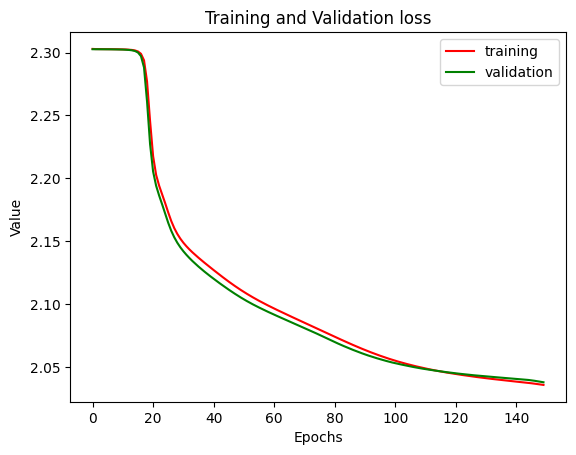

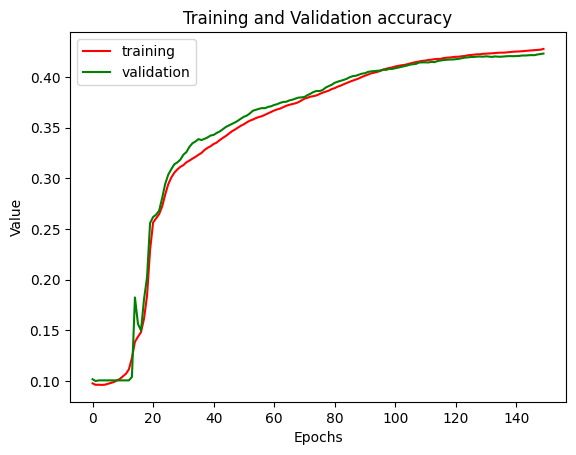

In [13]:
def draw_accuracy_loss(train, val, title):
    epochs = range(150)
    plt.plot(epochs, train, 'r', label='training')
    plt.plot(epochs, val, 'g', label='validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

draw_accuracy_loss(train_loss, val_loss, 'Training and Validation loss')
draw_accuracy_loss(train_accuracy, val_accuracy, 'Training and Validation accuracy')
